In [1]:
import bisect
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *
import networkx as nx

<br>

# Motivations: Evaluating Complex Expectations
---

As in part 1, our goal is to evaluate arbitrary function expectations under a probability density function $p$, but this time looking at **multivariate distributions**, with possibly some **observed variables**.

<br>

### Sampling multivariate distributions

The techniques discussed before are often not applicable when sampling for multivariate distribution. Inverse transform sampling requires the inversion of the cumulative probability function, which is even harder as the number of variables increase (although in some case, such as Gaussian, it is possible, while it is not possible for univariate gaussians).

As for rejection sampling and importance sampling, their behavior gets exponentially worse with the increasing number of dimensions: rejection sampling rejects almost with certainty, while importance sampling might focus most of its time sampling from low probability area.

<br>

### Sampling with observed variables

In the case of multivariate distributions, we also have to consider that in the general case, some of these variables will be fixed because observed. For some distributions, it will be possible to find a **closed form for the conditional distribution** (for instance with Gaussian Processes), but in many cases it will not.

Techniques such as rejection sampling can be adapted for such cases, for instance by rejecting samples for which the value of the observed values are not equal. But this only works for discrete variables, and even though we could make it work, passed a few observations, the number of rejected sample is so high that it is practically not useful.

<br>

# Ancestral Sampling
---

Ancestral sampling can be used when the **joint distribution can be decomposed** in a directed acyclic graph of conditional distributions (see Bayesian Network) and when the **observed variables are not too problematic**.

<br>

### Hypotheses

The joint distribution we want to sample from can be **decomposed** in a directed acyclic graph of dependencies, each dependency representing a **conditional probability distribution that is easily sampled**, for instance:

&emsp; $p(a,b,c,d,e,f) = p(a|b,c)p(b|d,e)p(c|d,e)p(d|e)p(e)p(f)$

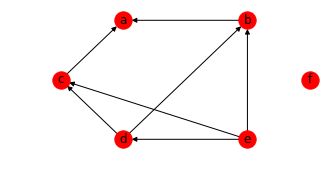

In [31]:
g = nx.DiGraph()
g.add_node("f")
g.add_edge("b", "a")
g.add_edge("c", "a")
g.add_edge("d", "b")
g.add_edge("e", "b")
g.add_edge("d", "c")
g.add_edge("e", "c")
g.add_edge("e", "d")
plt.figure(figsize=(4,2))
nx.draw_circular(g, with_labels=True)

<br>

### The technique

Simply sample from the distributions in the topological order, and use the values of the parents to condition the probability distribution of the children nodes. For instance, given the joint distribution:

&emsp; $p(a,b,c,d,e,f) = p(a|b,c)p(b|d,e)p(c|d,e)p(d|e)p(e)p(f)$

A valid sampling order is (there can be several, for instance for $f$):

&emsp; $p(f)$ and $p(e)$
&emsp; $\rightarrow$
&emsp; $p(d|e)$
&emsp; $\rightarrow$
&emsp; $p(b|d,e)$ and $p(c|d,e)$
&emsp; $\rightarrow$
&emsp; $p(a|b,c)$

<br>

### Pros and Cons

This technique is really good if each conditional probability can be easily sampled from. Each sample from the joint distribution is independent, which is a great property for it allows the sample average to quickly converge.

In case the conditional probability distributions are not ones from which it is easy is not possible, things gets rapidely bad. We might still be able to deal with some distributions with rejection sampling, but these distributions require to be univariate and not too numerous to be efficient.

The final problem of this technique is that we will often have observed variables. In such cases, this technique will not work. We could throw the samples that do not match the observed values, but that would only work for discrete variables and it gets very inefficient if the values are not likely or passed a few observations.

<br>

# Markov Chain Monte Carlo
---

The idea of the MCMC methods is to draw sample according to a Markov process. New samples are dependent of the previous sample that has been generated. MCMC is a very powerful technique whose main drawback is that the **samples are not independent anymore**. It might then be necessary to **sub-sample** to get samples that are as independent as possible.

<br>

### Basic idea

We want to sample $z \sim p$. To do this, we create a **proposal distribution** $q(z^*|z^t)$ which proposes new values of $z$ based on the previously sampled value. The proposal distribution can be widely different from the distribution $p$: it can be a gaussian centered on the previous $z$.

In the **Metropolis-Hasting** algorithm, the new sample is then accepted or rejected based on the ratio:

&emsp; $\displaystyle \boxed{A(z^t, z^*) = \operatorname{min}\big(1, \frac{p(z^*)q(z^t|z^*)}{p(z^t)q(z^*|z^t)} \big)}$
&emsp; where
&emsp; $\displaystyle \frac{p(z^*)q(z^t|z^*)}{p(z^t)q(z^*|z^t)} = \frac{p(z^*)}{p(z^t)}$
&emsp; if $q$ is symmetric

When a sample is accepted, its value becomes the new state $z^{t+1}$, otherwise the state of the Markov Chain remains the same. This generates a **trajectory** in the space of possible values. Ideally, we must select $q$ so that this trajectory is **as far away as possible to a random walk**, because random walks tends to explore the space very badly, and will lead to highly correlated samples.

<br>

### WHEN does it work?

The MCMC algorithm does not always work. In order for it to work, the distribution $p$ must be **invariant with respect to the Markov Chain**. This means that if we look at the samples $z$ generated, they should always follow the probability $p(z)$ at each time step:

&emsp; $\displaystyle \boxed{p(z^*) = \sum_{z'} p(z') \; T(z',z)}$
&emsp; where
&emsp; $T(z',z)$ is the transition probability from $z'$ to $z$ of the markov chain

A sufficient necessary condition for this to hold is the **detailed balance**, which can be interpreted as *the flow that comes comes out equally*, a kind of equilibrium between every pair of states:

&emsp; $\displaystyle \boxed{p(z') \; T(z', z) = p(z) \; T(z, z')}$
&emsp; $\implies$
&emsp; $\displaystyle \sum_{z'} p(z') \; T(z', z) = \sum_{z'} p(z) \; T(z, z') = \sum_{z'} p(z) \; q(z'|z) = p(z)$

We also need the Markov Chain to **converge to the invariant distribution (ergodicity)**. This is garantied in case the Markov Chain is homogenous (which means that $q$ is always the same given the previous state, for instance a gaussian distribution with always the same variance, centered on the previous state).

<br>

### Pro and Cons

The size of the step induced by $q$ is critical:

* the smaller the step, the higher the correlation between the samples
* the bigger the step, the higher the chances of rejection

Random walks take time to explore space, and so the behavior of the MCMC will highly depend on this step size.

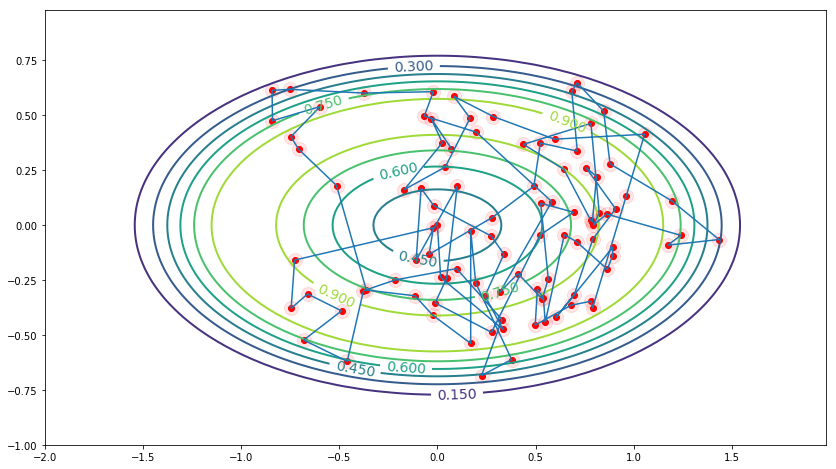

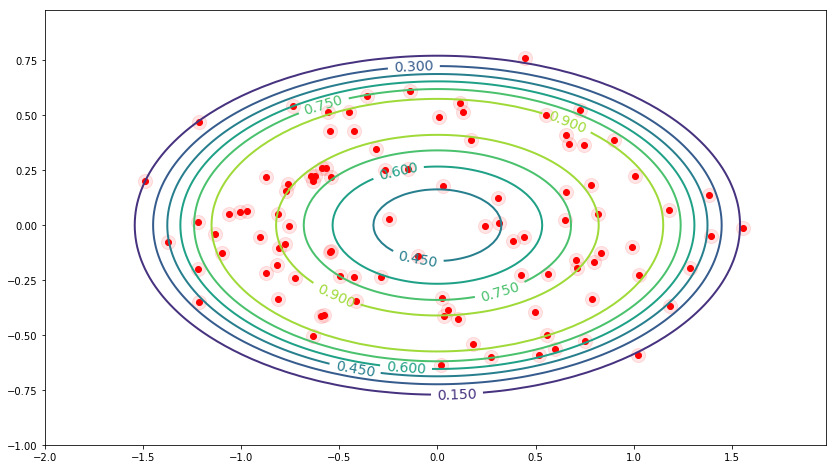

In [42]:
def p_pdf(x, y):
    return np.exp(- (x**2 + (2*y)**2 - 1)**2)


def mcmc_sampling(size: int):
    points = [np.array([0., 0.])]
    while len(points) <= size:
        z = points[-1]
        dz = np.random.normal(loc=0., scale=0.2, size=2)
        next_z = z + dz
        p_next_z = p_pdf(next_z[0], next_z[1])
        p_prev_z = p_pdf(z[0], z[1])
        if np.random.uniform(0., 1.) <= (p_next_z / p_prev_z):
            points.append(next_z)
    return np.stack(points)


def sub_sample(sampler, size: int):
    samples = sampler(size=size*100)
    np.random.shuffle(samples)
    return samples[:size]


def show_sampling(samples, show_trajectory: bool):
    xs = np.arange(-2., 2., 0.02)
    ys = np.arange(-1., 1., 0.02)
    X, Y = np.meshgrid(xs, ys)
    p_X_Y = p_pdf(X, Y)
    fig, ax = plt.subplots(figsize=(14, 8))
    CS = ax.contour(X, Y, p_X_Y, levels=8, linewidths=2, antialiased=True)
    if show_trajectory:
        ax.plot(samples[:,0], samples[:,1])
    ax.scatter(samples[:,0], samples[:,1], color='red')
    ax.scatter(samples[:,0], samples[:,1], s=200, color='red', alpha=0.1)
    ax.clabel(CS, inline=1, fontsize=14)
    plt.show()
    

show_sampling(samples=mcmc_sampling(100), show_trajectory=True)
show_sampling(samples=sub_sample(mcmc_sampling, 100), show_trajectory=False)

<br>

# Gibbs Sampling
---

Gibbs sampling a **special kind of MCMC**, where the proposal function is such that we consider one variable at each time, using its conditional distribution, and always accept the sample. This is particularly **suited to sampling with observed variables** which we can just ignore.

<br>

### Basic idea

We want to sample from $z \sim p(z_1 \dots z_N)$. The proposal function $q$ selects one of the dimension $z_i$ and draws one sample from the conditional distribution $p(z_i|z_{j \ne i})$. The new state is the previous $z^t$ with the $i^{th}$ component modified. If some variables are observed, we simply never sample from these variables.

<br>

### Pros and Cons

The practicality of Gibbs sampling **depends on the ease of sampling from the conditonal distribution** $p(z_i|z_{j \ne i})$. The kind of distribution is also potentially problematic: some shapes will force the Gibbs sampling algorithm to do a **long random walks** before reaching some part of the space.

In [33]:
# TODO - show on narrow gaussians